# Complex Bayesian Network notebook

#### Import dependencies

In [37]:
# Import dependencies
%pip install pgmpy
%pip install tabulate
%pip install pandas
%pip install networkx
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### Load libraries

In [38]:
# Load libraries
import pgmpy as pg
import tabulate as tb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import sklearn

## Data import and cleaning

#### Import BigPerf data

In [39]:
# Import data
df = pd.read_csv("..\\Data\\BigPerfMetrics.csv")

df.head()

,Block_ID,HDFS_BW,HDFSTranmissionTime,Mapper_ID,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_ID,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_ID.1,Block_BW,BlockTransmissionTime,TransactionTime
0,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer0,341739,480,3.80,250.14,reducer0_Block_1,0.0,0.00,1578.79
1,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer1,150000,120,50.00,18.99,reducer1_Block_1,50.0,20.00,1007.64
2,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer2,382530,480,4.48,212.22,reducer2_Block_1,3.7,270.02,1811.61
3,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer3,150000,120,5.88,161.57,reducer3_Block_1,3.7,270.02,1400.96
4,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,18.41,4.16,reducer4,457419,480,5.88,161.53,reducer4_Block_1,3.7,270.02,1761.83


#### Clean data of unwanted variables and missing values

In [40]:
# Clean data
df.dropna()

df.drop(labels=['Block_ID', 'Mapper_ID', 'Reducer_ID', 'Block_ID.1'], axis=1, inplace=True)

df.head()

,HDFS_BW,HDFSTranmissionTime,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_BW,BlockTransmissionTime,TransactionTime
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83


#### Rename columns to better fit in drawn charts and for ease of use

In [41]:
# Rename column headers to abbreviations

nodes = ['HBW', 'HTT', 'MMIPS', 'MET', 'MBW', 'MTT', 'RMIPS', 'RET', 'RBW', 'RTT', 'BBW', 'BTT', 'TT']

df.columns = nodes

df.head(10)

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83
5,11.81,80.63,652289,765.49,18.41,4.16,150000,120,6.98,136.24,3.7,270.02,1376.54
6,11.81,80.63,652289,765.49,18.41,4.16,563904,480,3.80,250.14,3.7,270.02,1850.44
7,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63
8,11.81,80.63,652289,765.49,18.41,4.16,430890,480,3.80,250.14,3.7,270.02,1850.44
9,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63


#### Define funtion to discretise data into three catagories

In [42]:
HBW_LABELS = ['1. Less than: 2.95 Mbps', '2. Between: 2.95 Mbps and 5.9 Mbps', '3. Between: 5.9 Mbps and 8.86 Mbps', '4. Greater than: 8.86 Mbps']
HTT_LABELS = ['1. Less than: 88.76 ms', '2. Between: 88.76 ms and 177.52 ms', '3. Between: 177.52 ms and 266.27 ms', '4. Greater than: 266.27 ms']
MMIPS_LABELS = ['1. Less than: 726605.75', '2. Between: 726605.75 and 800922.5', '3. Between: 800922.5 and 875239.25', '4. Greater than: 875239.25']
MET_LABELS = ['1. Less than: 943.85 ms', '2. Between: 943.85 ms and 1122.21 ms', '3. Between: 1122.21 ms and 1300.57 ms', '4. Greater than: 1300.57 ms']
MBW_LABELS = ['1. Less than: 8.62 Mbps', '2. Between: 8.62 Mbps and 15.75 Mbps', '3. Between: 15.75 Mbps and 22.87 Mbps', '4. Greater than: 22.87 Mbps']
MTT_LABELS = ['1. Less than: 14.5 ms', '2. Between: 14.5 ms and 26.5 ms', '3. Between: 26.5 ms and 38.51 ms', '4. Greater than: 38.51 ms']
RMIPS_LABELS = ['1. Less than: 253476', '2. Between: 253476 and 356952', '3. Between: 356952 and 460428', '4. Greater than: 460428']
RET_LABELS = ['1. Less than: 210 ms', '2. Between: 210 ms and 300 ms', '3. Between: 300 ms and 390.0 ms', '4. Greater than: 390.0 ms']
RBW_LABELS = ['1. Less than: 40.35 Mbps', '2. Between: 40.35 Mbps and 76.89 Mbps', '3. Between: 76.89 Mbps and 113.45 Mbps', '4. Greater than: 113.45 Mbps']
RTT_LABELS = ['1. Less than: 67.28 ms', '2. Between: 67.28 ms and 128.23 ms', '3. Between: 128.23 ms and 189.18 ms', '4. Greater than: 189.18 ms']
BBW_LABELS = ['1. Less than: 12.5 Mbps', '2. Between: 12.5 Mbps and 25 Mbps', '3. Between: 25 Mbps and 37 Mbps', '4. Greater than: 37 Mbps']
BTT_LABELS = ['1. Less than: 67.5 ms', '2. Between: 67.5 ms and 135 ms', '3. Between: 135 ms and 202.52 ms', '4. Greater than: 202.52 ms']
TT_LABELS = ['1. Less than: 1471.78 ms', '2. 1471.78 to 1935.93 ms', '3. 1935.93 to 2400.07 ms', '4. Greater than: 2400.07 ms']

In [43]:
def make_discrete(df):

    discrete_df = pd.DataFrame()

    discrete_df['HBW'] = pd.cut(df['HBW'], bins=4, labels=HBW_LABELS, ordered=True, precision=2)
    discrete_df['HTT'] = pd.cut(df['HTT'], bins=4, labels=HTT_LABELS, ordered=True, precision=2)
    discrete_df['MMIPS'] = pd.cut(df['MMIPS'], bins=4, labels=MMIPS_LABELS, ordered=True, precision=2)
    discrete_df['MET'] = pd.cut(df['MET'], bins=4, labels=MET_LABELS, ordered=True, precision=2)
    discrete_df['MBW'] = pd.cut(df['MBW'], bins=4, labels=MBW_LABELS, ordered=True, precision=2)
    discrete_df['MTT'] = pd.cut(df['MTT'], bins=4, labels=MTT_LABELS, ordered=True, precision=2)
    discrete_df['RMIPS'] = pd.cut(df['RMIPS'], bins=4, labels=RMIPS_LABELS, ordered=True, precision=2)
    discrete_df['RET'] = pd.cut(df['RET'], bins=4, labels=RET_LABELS, ordered=True, precision=2)
    discrete_df['RBW'] = pd.cut(df['RBW'], bins=4, labels=RBW_LABELS, ordered=True, precision=2)
    discrete_df['RTT'] = pd.cut(df['RTT'], bins=4, labels=RTT_LABELS, ordered=True, precision=2)
    discrete_df['BBW'] = pd.cut(df['BBW'], bins=4, labels=BBW_LABELS, ordered=True, precision=2)
    discrete_df['BTT'] = pd.cut(df['BTT'], bins=4, labels=BTT_LABELS, ordered=True, precision=2)
    discrete_df['TT'] = pd.cut(df['TT'], bins=4, labels=TT_LABELS, ordered=True, precision=2)

    discrete_df = discrete_df.astype('object')

    return discrete_df

#### Discretise data into catagories

In [44]:
# Discretise BigPerf dataset
cat_df = make_discrete(df)

df.dropna(inplace=True)

#cat_df.to_csv('data\\discretised_bigperf.csv')

cat_df.head(100)

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,4. Greater than: 8.86 Mbps,1. Less than: 88.76 ms,1. Less than: 726605.75,1. Less than: 943.85 ms,4. Greater than: 22.87 Mbps,1. Less than: 14.5 ms,2. Between: 253476 and 356952,4. Greater than: 390.0 ms,1. Less than: 40.35 Mbps,4. Greater than: 189.18 ms,1. Less than: 12.5 Mbps,1. Less than: 67.5 ms,2. 1471.78 to 1935.93 ms
1,4. Greater than: 8.86 Mbps,1. Less than: 88.76 ms,1. Less than: 726605.75,1. Less than: 943.85 ms,4. Greater than: 22.87 Mbps,1. Less than: 14.5 ms,1. Less than: 253476,1. Less than: 210 ms,2. Between: 40.35 Mbps and 76.89 Mbps,1. Less than: 67.28 ms,4. Greater than: 37 Mbps,1. Less than: 67.5 ms,1. Less than: 1471.78 ms
2,4. Greater than: 8.86 Mbps,1. Less than: 88.76 ms,1. Less than: 726605.75,1. Less than: 943.85 ms,3. Between: 15.75 Mbps and 22.87 Mbps,1. Less than: 14.5 ms,3. Between: 356952 and 460428,4. Greater than: 390.0 ms,1. Less than: 40.35 Mbps,4. Greater than: 189.18 ms,1. Less than: 12.5 Mbps,4. Greater than: 202.52 ms,2. 1471.78 to 1935.93 ms
3,4. Greater than: 8.86 Mbps,1. Less than: 88.76 ms,1. Less than: 726605.75,1. Less than: 943.85 ms,3. Between: 15.75 Mbps and 22.87 Mbps,1. Less than: 14.5 ms,1. Less than: 253476,1. Less than: 210 ms,1. Less than: 40.35 Mbps,3. Between: 128.23 ms and 189.18 ms,1. Less than: 12.5 Mbps,4. Greater than: 202.52 ms,1. Less than: 1471.78 ms
4,4. Greater than: 8.86 Mbps,1. Less than: 88.76 ms,1. Less than: 726605.75,1. Less than: 943.85 ms,3. Between: 15.75 Mbps and 22.87 Mbps,1. Less than: 14.5 ms,3. Between: 356952 and 460428,4. Greater than: 390.0 ms,1. Less than: 40.35 Mbps,3. Between: 128.23 ms and 189.18 ms,1. Less than: 12.5 Mbps,4. Greater than: 202.52 ms,2. 1471.78 to 1935.93 ms
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1. Less than: 2.95 Mbps,4. Greater than: 266.27 ms,1. Less than: 726605.75,1. Less than: 943.85 ms,1. Less than: 8.62 Mbps,2. Between: 14.5 ms and 26.5 ms,1. Less than: 253476,1. Less than: 210 ms,1. Less than: 40.35 Mbps,3. Between: 128.23 ms and 189.18 ms,1. Less than: 12.5 Mbps,4. Greater than: 202.52 ms,2. 1471.78 to 1935.93 ms
96,1. Less than: 2.95 Mbps,4. Greater than: 266.27 ms,1. Less than: 726605.75,1. Less than: 943.85 ms,1. Less than: 8.62 Mbps,2. Between: 14.5 ms and 26.5 ms,4. Greater than: 460428,4. Greater than: 390.0 ms,1. Less than: 40.35 Mbps,4. Greater than: 189.18 ms,1. Less than: 12.5 Mbps,4. Greater than: 202.52 ms,3. 1935.93 to 2400.07 ms
97,1. Less than: 2.95 Mbps,4. Greater than: 266.27 ms,1. Less than: 726605.75,1. Less than: 943.85 ms,1. Less than: 8.62 Mbps,2. Between: 14.5 ms and 26.5 ms,1. Less than: 253476,1. Less than: 210 ms,4. Greater than: 113.45 Mbps,1. Less than: 67.28 ms,1. Less than: 12.5 Mbps,4. Greater than: 202.52 ms,2. 1471.78 to 1935.93 ms
98,1. Less than: 2.95 Mbps,4. Greater than: 266.27 ms,1. Less than: 726605.75,1. Less than: 943.85 ms,1. Less than: 8.62 Mbps,1. Less than: 14.5 ms,3. Between: 356952 and 460428,4. Greater than: 390.0 ms,1. Less than: 40.35 Mbps,4. Greater than: 189.18 ms,1. Less than: 12.5 Mbps,4. Greater than: 202.52 ms,3. 1935.93 to 2400.07 ms


In [45]:
for column in cat_df:
    print(cat_df.groupby(column)[column].count().reset_index(name='Count').to_dict(orient='records'))

[{'HBW': '1. Less than: 2.95 Mbps', 'Count': 1122}, {'HBW': '4. Greater than: 8.86 Mbps', 'Count': 1418}]
[{'HTT': '1. Less than: 88.76 ms', 'Count': 1436}, {'HTT': '4. Greater than: 266.27 ms', 'Count': 1104}]
[{'MMIPS': '1. Less than: 726605.75', 'Count': 675}, {'MMIPS': '2. Between: 726605.75 and 800922.5', 'Count': 628}, {'MMIPS': '3. Between: 800922.5 and 875239.25', 'Count': 533}, {'MMIPS': '4. Greater than: 875239.25', 'Count': 704}]
[{'MET': '1. Less than: 943.85 ms', 'Count': 675}, {'MET': '2. Between: 943.85 ms and 1122.21 ms', 'Count': 628}, {'MET': '3. Between: 1122.21 ms and 1300.57 ms', 'Count': 533}, {'MET': '4. Greater than: 1300.57 ms', 'Count': 704}]
[{'MBW': '1. Less than: 8.62 Mbps', 'Count': 2137}, {'MBW': '2. Between: 8.62 Mbps and 15.75 Mbps', 'Count': 52}, {'MBW': '3. Between: 15.75 Mbps and 22.87 Mbps', 'Count': 114}, {'MBW': '4. Greater than: 22.87 Mbps', 'Count': 237}]
[{'MTT': '1. Less than: 14.5 ms', 'Count': 503}, {'MTT': '2. Between: 14.5 ms and 26.5 ms',

In [46]:
# for column in cat_df:
#     print (column)
#     print (cat_df[column].unique())
#     print('\n')

In [47]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(cat_df, test_size=0.2, random_state=20)

## Building the model

#### Import dependencies

In [48]:
import networkx as nx
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch

#### Use structure learning to build a DAG

In [49]:
hc = HillClimbSearch(data=training_data)
estimate = hc.estimate(scoring_method='k2score')

  0%|          | 23/1000000 [00:01<23:29:04, 11.83it/s]


#### Generate a Bayesian Network object using the learned DAG

In [50]:
model = BayesianModel(estimate.edges)

#### Fit the created BN model to the BigPerf data, in order to create probability distributions

In [51]:
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from IPython.core.display import display, HTML

# disable text wrapping in output cell
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

model.cpds = []

model.fit(data=training_data,
    estimator=BayesianEstimator,
    prior_type='BDeu',
    complete_samples_only=True)

#### Plot the model as a graph

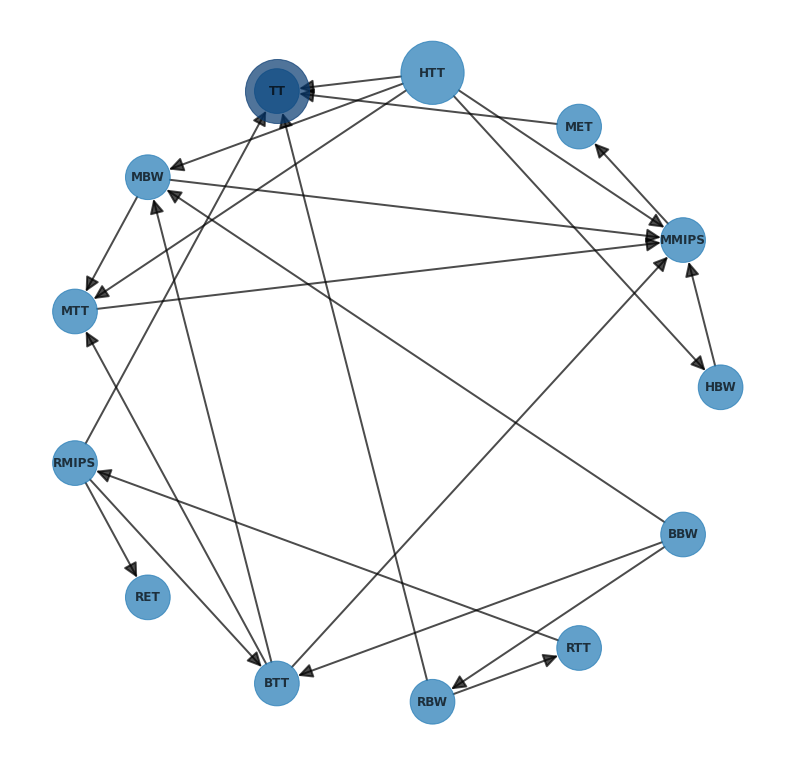

In [52]:
plt.figure(3,figsize=(14,14)) 
G = nx.DiGraph()
G.add_edges_from(model.edges)


G.add_nodes_from(model.nodes)
pos = nx.circular_layout(G)
DAG = G.to_directed()
nx.topological_sort(DAG)

nx.draw_networkx(G,
                pos=pos,
                with_labels=True,
                node_size=[2000,2000,2000,4000,2000,2000,2000,2000,2000,2000,2000,2000,2000],
                arrowsize=30,
                alpha=0.7,
                font_weight="bold",
                width=2.0)  # Draw the original graph

tt_g = G.subgraph(nodes=['TT'])
nx.draw(tt_g, pos=pos, with_labels=False, arrowsize=0, node_size=4100, alpha=0.7, font_weight="bold", node_color='#063970')

# sub_g = G.subgraph(nodes=['MET', 'HTT', 'RBW', 'RMIPS'])
# nx.draw(sub_g, pos=pos, with_labels=False, arrowsize=0, node_size=1400, alpha=0.7, font_weight="bold", node_color='#FFA500')  # Draw the original graph
plt.show()

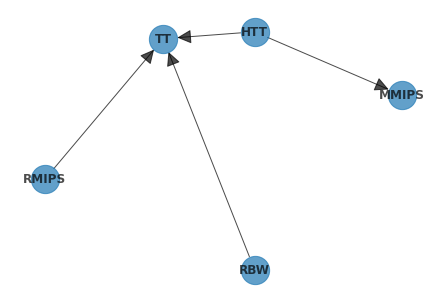

In [55]:
sub_g = G.subgraph(nodes=['MMIPS', 'HTT', 'RBW', 'RMIPS', 'TT'])
nx.draw(sub_g, pos=pos, with_labels=True, arrowsize=30, node_size=800, alpha=0.7, font_weight="bold")  # Draw the original graph
plt.show()

## Scoring the model

#### Collect prediction accuracy scores for all variables

#### Get structure correlation scores

#### Store model metrics to a file for visualisation

## Reasoning using inference queries

In [56]:
# Initializing the VariableElimination class

from pgmpy.inference import VariableElimination
from pgmpy.inference.ExactInference import BeliefPropagation

bigPerf_infer = VariableElimination(model=model)

#### Query best case of TT

In [57]:
# Compute probabilities of parent variables of TT when TT is Very Low
q_tt = bigPerf_infer.query(variables=['HTT', 'MMIPS', 'RTT', 'BTT', 'RMIPS'], evidence={'TT': TT_LABELS[0]}, joint=False)

#print(query)
for factor in q_tt.values():
    print(factor)

Eliminating: BBW: 100%|██████████| 7/7 [00:00<00:00, 207.76it/s]

+---------------------------------+------------+
| HTT                             |   phi(HTT) |
+=================================+============+
| HTT(1. Less than: 88.76 ms)     |     0.8372 |
+---------------------------------+------------+
| HTT(4. Greater than: 266.27 ms) |     0.1628 |
+---------------------------------+------------+
+-------------------------------------------+--------------+
| MMIPS                                     |   phi(MMIPS) |
+===========================================+==============+
| MMIPS(1. Less than: 726605.75)            |       0.6699 |
+-------------------------------------------+--------------+
| MMIPS(2. Between: 726605.75 and 800922.5) |       0.2473 |
+-------------------------------------------+--------------+
| MMIPS(3. Between: 800922.5 and 875239.25) |       0.0801 |
+-------------------------------------------+--------------+
| MMIPS(4. Greater than: 875239.25)         |       0.0026 |
+-------------------------------------------+--

#### Query worst case of TT

In [58]:
# Compute probabilities of parent variables of TT when TT is Very Low
q_tt_worst = bigPerf_infer.query(variables=['HTT', 'MET', 'RBW', 'RMIPS'], evidence={'TT': TT_LABELS[3]}, joint=False)

#print(query)
for factor in q_tt_worst.values():
    print(factor)

Eliminating: HBW: 100%|██████████| 8/8 [00:00<00:00, 68.01it/s]

+---------------------------------+------------+
| HTT                             |   phi(HTT) |
+=================================+============+
| HTT(1. Less than: 88.76 ms)     |     0.3307 |
+---------------------------------+------------+
| HTT(4. Greater than: 266.27 ms) |     0.6693 |
+---------------------------------+------------+
+--------------------------------------------+------------+
| MET                                        |   phi(MET) |
+============================================+============+
| MET(1. Less than: 943.85 ms)               |     0.0011 |
+--------------------------------------------+------------+
| MET(2. Between: 943.85 ms and 1122.21 ms)  |     0.0919 |
+--------------------------------------------+------------+
| MET(3. Between: 1122.21 ms and 1300.57 ms) |     0.2036 |
+--------------------------------------------+------------+
| MET(4. Greater than: 1300.57 ms)           |     0.7035 |
+--------------------------------------------+-----------

#### Query best case of RET

In [59]:
q_ret_best = bigPerf_infer.query(variables=['RMIPS'], evidence={'RET': RET_LABELS[0]}, joint=False)

#print(query)
for factor in q_ret_best.values():
    print(factor)

Eliminating: HBW: 100%|██████████| 11/11 [00:00<00:00, 30.59it/s] 

+--------------------------------------+--------------+
| RMIPS                                |   phi(RMIPS) |
+======================================+==============+
| RMIPS(1. Less than: 253476)          |       0.9982 |
+--------------------------------------+--------------+
| RMIPS(2. Between: 253476 and 356952) |       0.0006 |
+--------------------------------------+--------------+
| RMIPS(3. Between: 356952 and 460428) |       0.0006 |
+--------------------------------------+--------------+
| RMIPS(4. Greater than: 460428)       |       0.0006 |
+--------------------------------------+--------------+


#### Query worst case of RET

In [60]:
q_ret_worst = bigPerf_infer.query(variables=['RMIPS'], evidence={'RET': RET_LABELS[3]}, joint=False)

#print(query)
for factor in q_ret_worst.values():
    print(factor)

Eliminating: HBW: 100%|██████████| 11/11 [00:00<00:00, 25.12it/s] 

+--------------------------------------+--------------+
| RMIPS                                |   phi(RMIPS) |
+======================================+==============+
| RMIPS(1. Less than: 253476)          |       0.0006 |
+--------------------------------------+--------------+
| RMIPS(2. Between: 253476 and 356952) |       0.2015 |
+--------------------------------------+--------------+
| RMIPS(3. Between: 356952 and 460428) |       0.6003 |
+--------------------------------------+--------------+
| RMIPS(4. Greater than: 460428)       |       0.1976 |
+--------------------------------------+--------------+


#### Query best case of MET

In [61]:
q_met_best = bigPerf_infer.query(variables=['MMIPS'], evidence={'MET': MET_LABELS[0]}, joint=False)

for factor in q_met_best.values():
    print(factor)

Eliminating: HTT: 100%|██████████| 11/11 [00:00<00:00, 465.39it/s]

+-------------------------------------------+--------------+
| MMIPS                                     |   phi(MMIPS) |
+===========================================+==============+
| MMIPS(1. Less than: 726605.75)            |       0.9982 |
+-------------------------------------------+--------------+
| MMIPS(2. Between: 726605.75 and 800922.5) |       0.0006 |
+-------------------------------------------+--------------+
| MMIPS(3. Between: 800922.5 and 875239.25) |       0.0006 |
+-------------------------------------------+--------------+
| MMIPS(4. Greater than: 875239.25)         |       0.0006 |
+-------------------------------------------+--------------+


#### Query worst case of MET

In [62]:
q_met_worst = bigPerf_infer.query(variables=['MMIPS'], evidence={'MET': MET_LABELS[3]}, joint=False)

for factor in q_met_worst.values():
    print(factor)

Eliminating: HTT: 100%|██████████| 11/11 [00:00<00:00, 478.43it/s]

+-------------------------------------------+--------------+
| MMIPS                                     |   phi(MMIPS) |
+===========================================+==============+
| MMIPS(1. Less than: 726605.75)            |       0.0006 |
+-------------------------------------------+--------------+
| MMIPS(2. Between: 726605.75 and 800922.5) |       0.0006 |
+-------------------------------------------+--------------+
| MMIPS(3. Between: 800922.5 and 875239.25) |       0.0006 |
+-------------------------------------------+--------------+
| MMIPS(4. Greater than: 875239.25)         |       0.9983 |
+-------------------------------------------+--------------+


## Print the model's combined probability distributions

In [63]:
print(f'Check model: {model.check_model()}\n')
for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

Check model: True

CPT of HBW:
+---------------------------------+-----------------------------+---------------------------------+
| HTT                             | HTT(1. Less than: 88.76 ms) | HTT(4. Greater than: 266.27 ms) |
+---------------------------------+-----------------------------+---------------------------------+
| HBW(1. Less than: 2.95 Mbps)    | 0.014260640631856078        | 0.9986072423398329              |
+---------------------------------+-----------------------------+---------------------------------+
| HBW(4. Greater than: 8.86 Mbps) | 0.9857393593681439          | 0.001392757660167131            |
+---------------------------------+-----------------------------+---------------------------------+ 

CPT of MMIPS:
+-------------------------------------------+------------------------------+--------------------------------------+---------------------------------------+--------------------------------+-------------------------------------------+---------------------